## Reading and merging the data

In [9]:
import json

with open("data/match_1.json", "r") as file:
    match_data_1 = json.load(file)

# Check the type of the loaded data and get the number of gaits (entries) in the dataset
data_type = type(match_data_1)
num_gaits = len(match_data_1)

data_type, num_gaits

(list, 574)

In [16]:
import json

with open("data/match_2.json", "r") as file:
    match_data_2 = json.load(file)

# Check the type of the loaded data and get the number of gaits (entries) in the dataset
data_type = type(match_data_2)
num_gaits = len(match_data_2)

data_type, num_gaits

(list, 613)

In [58]:
import pandas as pd

# Merge the two datasets (match_1_data and match_2_data) and add a "match_id" identifier

# Add match_id to match_1_data
for gait in match_data_1:
    gait['match_id'] = 1

# Add match_id to match_2_data
for gait in match_data_2:
    gait['match_id'] = 2

# Merge the two datasets
combined_data = match_data_1 + match_data_2

# Convert the combined_data to a DataFrame
df = pd.DataFrame(combined_data)

In [59]:
df.head(10)

,label,norm,match_id
0,walk,"[23.177037336396975, 23.36152528524938, 21.535...",1
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...",1
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...",1
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...",1
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...",1
5,walk,"[19.92032356700904, 19.672270483203395, 18.688...",1
6,walk,"[72.43782600710844, 29.1545534760874, 51.00451...",1
7,walk,"[56.86645792611747, 24.06617147011633, 39.4051...",1
8,run,"[34.587473483674074, 33.423278993730264, 21.71...",1
9,run,"[10.642204698384765, 27.15560347765402, 40.427...",1


## **Approach: Stochastic Transition Matrix-Based Game Generation**


In [127]:
# Create a shifted version of the label column to represent the next action
df['next_label'] = df['label'].shift(-1)

# Filter out rows where the next action belongs to a different match
df['next_match'] = df['match_id'].shift(-1)
df.loc[df['match_id'] != df['next_match'], 'next_label'] = None

# Creating a pivot table to get the counts of each transition
transition_counts = df.groupby(['label', 'next_label']).size().unstack(fill_value=0)

# Convert counts to probabilities by dividing by the row sum
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

In [128]:
transition_matrix

next_label,cross,dribble,no action,pass,rest,run,shot,tackle,walk
label,,,,,,,,,
cross,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.000000,0.000000,0.250000
dribble,0.038462,0.500000,0.000000,0.230769,0.000000,0.102564,0.089744,0.000000,0.038462
no action,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000
pass,0.031250,0.125000,0.000000,0.156250,0.093750,0.281250,0.000000,0.000000,0.312500
rest,0.000000,0.000000,0.000000,0.028571,0.000000,0.171429,0.000000,0.000000,0.800000
run,0.000000,0.039927,0.000000,0.009074,0.007260,0.787659,0.009074,0.034483,0.112523
shot,0.000000,0.055556,0.055556,0.000000,0.000000,0.222222,0.333333,0.000000,0.333333
tackle,0.000000,0.129032,0.000000,0.000000,0.000000,0.483871,0.000000,0.225806,0.161290
walk,0.000000,0.018433,0.000000,0.004608,0.062212,0.170507,0.000000,0.011521,0.732719


In [136]:
def generate_game(start_action, desired_duration_minutes):
    game_sequence = [start_action]
    total_duration = 0
    
    while total_duration < desired_duration_minutes * 60:  # Convert minutes to seconds
        current_action = game_sequence[-1]
        next_action_choices = transition_matrix.columns
        next_action_probabilities = transition_matrix.loc[current_action].values
        
        next_action = np.random.choice(next_action_choices, p=next_action_probabilities)
        game_sequence.append(next_action)
        
        # Increment total_duration with average gait duration for the chosen action
        avg_gait_duration = df[df['label'] == next_action]['gait_duration'].mean()
        total_duration += avg_gait_duration
        
    return game_sequence

In [174]:
# Generate the 9-minute game sequence again
sample_game_9min = generate_game(start_action="walk", desired_duration_minutes=9)

# Count the occurrences of each action in the sample game
sample_game_counts = pd.Series(sample_game_9min).value_counts(normalize=True) * 100

# Get the distribution of actions in the original games (match_1 and match_2)
match_1_counts = df[df['match_id'] == 1]['label'].value_counts(normalize=True) * 100
match_2_counts = df[df['match_id'] == 2]['label'].value_counts(normalize=True) * 100

# Combine the distributions into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Sample Game (9 min)': sample_game_counts,
    'Match 1': match_1_counts,
    'Match 2': match_2_counts
}).fillna(0)

comparison_df.sort_values(by='Sample Game (9 min)', ascending=False)


,Sample Game (9 min),Match 1,Match 2
run,44.117647,36.411150,55.954323
walk,35.986159,42.682927,30.995106
dribble,9.169550,7.317073,5.872757
pass,3.460208,4.181185,1.305057
rest,2.941176,4.355401,1.631321
tackle,2.595156,3.484321,1.794454
shot,1.211073,1.045296,1.957586
cross,0.519031,0.522648,0.163132
no action,0.000000,0.000000,0.326264


This simple approach seems to capture the general dynamics and flow of a football match, as seen in the original data. 

It's a straightforward approach still, and requires further tuning.

For example, let's take a look at the average succession rate of each label and compare it to our stimulated game:

In [175]:
# Redefining the necessary functions

def consecutive_counts(actions):
    """
    Compute the counts of consecutive occurrences of each action.
    """
    consecutive_counts = {label: [] for label in set(actions)}
    
    count = 1
    prev_action = actions[0]
    
    for action in actions[1:]:
        if action == prev_action:
            count += 1
        else:
            consecutive_counts[prev_action].append(count)
            count = 1
        prev_action = action
    consecutive_counts[prev_action].append(count)  # For the last action
    
    return consecutive_counts

def average_consecutive_counts(consecutive_counts):
    """
    Calculate the average number of consecutive occurrences for each action.
    """
    avg_counts = {}
    for action, counts in consecutive_counts.items():
        avg_counts[action] = sum(counts) / len(counts) if counts else 0
    
    return avg_counts

def max_consecutive_counts(consecutive_counts):
    """
    Calculate the maximum number of consecutive occurrences for each action.
    """
    max_counts = {}
    for action, counts in consecutive_counts.items():
        max_counts[action] = max(counts) if counts else 0
    
    return max_counts

In [176]:
# Extract the labels for each match
match_1_labels = [entry['label'] for entry in match_data_1]
match_2_labels = [entry['label'] for entry in match_data_2]

# Compute the consecutive counts and average counts for the two matches and the simulated game
consecutive_counts_1 = consecutive_counts(match_1_labels)
consecutive_counts_2 = consecutive_counts(match_2_labels)
consecutive_counts_simulated = consecutive_counts(sample_game_9min)

average_counts_1 = average_consecutive_counts(consecutive_counts_1)
average_counts_2 = average_consecutive_counts(consecutive_counts_2)
average_counts_simulated = average_consecutive_counts(consecutive_counts_simulated)

In [177]:
# Compute the max consecutive counts for the two matches and the simulated game
max_counts_1 = max_consecutive_counts(consecutive_counts_1)
max_counts_2 = max_consecutive_counts(consecutive_counts_2)
max_counts_simulated = max_consecutive_counts(consecutive_counts_simulated)

In [178]:
# Creating a DataFrame with average_counts_1, average_counts_2, and average_counts_simulated as columns
succession_df = pd.DataFrame({
    'Match_1': average_counts_1,
    'Match_2': average_counts_2,
    'Simulated_Game': average_counts_simulated
})

succession_df.reset_index(inplace=True)
succession_df

,index,Match_1,Match_2,Simulated_Game
0,shot,1.500000,1.500000,1.400000
1,dribble,1.826087,2.250000,2.650000
2,walk,4.016393,3.392857,3.466667
3,rest,1.000000,1.000000,1.000000
4,pass,1.263158,1.000000,1.176471
5,cross,1.000000,1.000000,1.000000
6,tackle,1.428571,1.100000,1.500000
7,run,3.483333,5.913793,4.396552
8,no action,NaN,1.000000,NaN


In [179]:
# Creating a DataFrame with average_counts_1, average_counts_2, and average_counts_simulated as columns
succession_df = pd.DataFrame({
    'Match_1': max_counts_1,
    'Match_2': max_counts_2,
    'Simulated_Game': max_counts_simulated
})

succession_df.reset_index(inplace=True)
succession_df

,index,Match_1,Match_2,Simulated_Game
0,shot,2.0,2,2.0
1,dribble,7.0,5,6.0
2,walk,16.0,16,11.0
3,rest,1.0,1,1.0
4,pass,3.0,1,2.0
5,cross,1.0,1,1.0
6,tackle,3.0,2,3.0
7,run,17.0,30,19.0
8,no action,NaN,1,NaN


In [184]:
sample_game_9min[-5:]

['run', 'run', 'walk', 'walk', 'walk']

In [181]:
df.groupby('match_id')['label'].tail()

569       walk
570       walk
571        run
572     tackle
573        run
1182      walk
1183      walk
1184      walk
1185      walk
1186      walk
Name: label, dtype: object

In [182]:
sample_game_9min[:5]

['walk', 'walk', 'run', 'run', 'run']

In [183]:
df.groupby('match_id')['label'].head()

0           walk
1           walk
2           walk
3           walk
4           rest
574    no action
575          run
576         pass
577         rest
578         walk
Name: label, dtype: object

Let's see if we can add some constraints to our algorithm.

For example :
- No game should start with 'shot' or 'tackle'
- The game should not end with a 'shot' (debatable)
- There are no more than two consecutive 'shot' actions

In [185]:
def generate_game_with_constraints(start_action, desired_duration_minutes):
    game_sequence = [start_action]
    total_duration = 0
    consecutive_action_count = 1  # To keep track of consecutive actions
    
    constrained_actions = {'shot': 2, 'cross': 1, 'tackle': 2, 'rest':1}  # Actions with constraints
    
    while total_duration < desired_duration_minutes * 60:  # Convert minutes to seconds
        current_action = game_sequence[-1]
        
        # Check for constrained actions and count
        if len(game_sequence) > 1 and game_sequence[-1] == game_sequence[-2]:
            consecutive_action_count += 1
        else:
            consecutive_action_count = 1
        
        # Getting possible next actions and probabilities
        next_action_choices = list(transition_matrix.columns)
        next_action_probabilities = transition_matrix.loc[current_action].values.copy()
        
        # Apply constraints: If limit reached, set probability to zero for the next same action
        if current_action in constrained_actions and consecutive_action_count >= constrained_actions[current_action]:
            action_index = next_action_choices.index(current_action)
            next_action_probabilities[action_index] = 0
            next_action_probabilities /= sum(next_action_probabilities)  # Normalizing probabilities
        
        # Choose next action based on adjusted probabilities
        next_action = np.random.choice(next_action_choices, p=next_action_probabilities)
        game_sequence.append(next_action)
        
        # Increment total_duration with average gait duration for the chosen action
        avg_gait_duration = df[df['label'] == next_action]['gait_duration'].mean()
        total_duration += avg_gait_duration
        
    return game_sequence


In [206]:
# Generate a sample game with constraints for testing
sample_game_with_constraints = generate_game_with_constraints('run', 9)  # 9-minute game

In [207]:
# Count the occurrences of each action in the sample game
sample_game_counts = pd.Series(sample_game_with_constraints).value_counts(normalize=True) * 100

# Combine the distributions into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Sample Game (9 min)': sample_game_counts,
    'Match 1': match_1_counts,
    'Match 2': match_2_counts
}).fillna(0)

comparison_df.sort_values(by='Sample Game (9 min)', ascending=False)

,Sample Game (9 min),Match 1,Match 2
run,45.454545,36.411150,55.954323
walk,38.636364,42.682927,30.995106
dribble,5.419580,7.317073,5.872757
tackle,3.496503,3.484321,1.794454
rest,2.797203,4.355401,1.631321
pass,2.447552,4.181185,1.305057
shot,1.398601,1.045296,1.957586
cross,0.174825,0.522648,0.163132
no action,0.174825,0.000000,0.326264


In [213]:
consecutive_counts_simulated = consecutive_counts(sample_game_with_constraints)
average_counts_simulated = average_consecutive_counts(consecutive_counts_simulated)
max_counts_simulated = max_consecutive_counts(consecutive_counts_simulated)

comparaison_df = pd.DataFrame({
    'Avg_Match_1': average_counts_1,
    'Avg_Match_2': average_counts_2,
    'Avg_Simulated_Game': average_counts_simulated,
    'Max_Match_1': max_counts_1,
    'Max_Match_2': max_counts_2,
    'Max_Simulated_Game': max_counts_simulated
})

comparaison_df.reset_index(inplace=True)
comparaison_df

,index,Avg_Match_1,Avg_Match_2,Avg_Simulated_Game,Max_Match_1,Max_Match_2,Max_Simulated_Game
0,shot,1.500000,1.500000,1.142857,2.0,2,2
1,dribble,1.826087,2.250000,1.722222,7.0,5,4
2,walk,4.016393,3.392857,4.092593,16.0,16,14
3,rest,1.000000,1.000000,1.000000,1.0,1,1
4,pass,1.263158,1.000000,1.076923,3.0,1,2
5,cross,1.000000,1.000000,1.000000,1.0,1,1
6,tackle,1.428571,1.100000,1.111111,3.0,2,2
7,run,3.483333,5.913793,4.406780,17.0,30,16
8,no action,NaN,1.000000,1.000000,NaN,1,1


Now let's add another argument to our algorithm which allows us to control the style of the game (attacking, defensive, or neutral)

In [227]:
def generate_game_with_style(start_action, desired_duration_minutes, game_style):
    game_sequence = [start_action]
    total_duration = 0
    consecutive_action_count = 1  # To keep track of consecutive actions
    
    constrained_actions = {'shot': 2, 'cross': 1, 'tackle': 2, 'rest':1}  # Actions with constraints
    
    # Adjusting probabilities based on game style
    adjustment_factors = {
        'attacking': {'shot': 2, 'pass': 2, 'dribble': 1.5, 'cross':2},
        'defensive': {'tackle': 2, 'run': 2, 'pass': 0.5, 'dribble': 0.5}
    }
    
    while total_duration < desired_duration_minutes * 60:  # Convert minutes to seconds
        current_action = game_sequence[-1]
        
        # Check for constrained actions and count
        if len(game_sequence) > 1 and game_sequence[-1] == game_sequence[-2]:
            consecutive_action_count += 1
        else:
            consecutive_action_count = 1
        
        # Getting possible next actions and probabilities
        next_action_choices = list(transition_matrix.columns)
        next_action_probabilities = transition_matrix.loc[current_action].values.copy()
        
        # Apply game style adjustments
        if game_style in adjustment_factors:
            for action, factor in adjustment_factors[game_style].items():
                if action in next_action_choices:
                    action_index = next_action_choices.index(action)
                    next_action_probabilities[action_index] *= factor
            
            # Normalize the probabilities after adjustment
            next_action_probabilities /= sum(next_action_probabilities)
        
        # Apply constraints: If limit reached, set probability to zero for the next same action
        if current_action in constrained_actions and consecutive_action_count >= constrained_actions[current_action]:
            action_index = next_action_choices.index(current_action)
            next_action_probabilities[action_index] = 0
            next_action_probabilities /= sum(next_action_probabilities)  # Normalizing probabilities
        
        # Choose next action based on adjusted probabilities
        next_action = np.random.choice(next_action_choices, p=next_action_probabilities)
        game_sequence.append(next_action)
        
        # Increment total_duration with average gait duration for the chosen action
        avg_gait_duration = df[df['label'] == next_action]['gait_duration'].mean()
        total_duration += avg_gait_duration
        
    return game_sequence

In [228]:
sample_attacking_game = generate_game_with_style('run', 9, 'attacking')  # 9-minute attacking game
sample_defensive_game = generate_game_with_style('run', 9, 'defensive')  # 9-minute defensive game
sample_neutral_game = generate_game_with_style('run', 9, 'neutral')  # 9-minute neutral game

In [229]:
# Count the occurrences of each action in the sample game
sample_attacking_game_counts = pd.Series(sample_attacking_game).value_counts(normalize=True) * 100
sample_defensive_game_counts = pd.Series(sample_defensive_game).value_counts(normalize=True) * 100
sample_neutral_game_counts = pd.Series(sample_neutral_game).value_counts(normalize=True) * 100

# Combine the distributions into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Match 1': match_1_counts,
    'Match 2': match_2_counts,
    'Attacking game' : sample_attacking_game_counts,
    'Neutral game' : sample_neutral_game_counts,
    'Defensive game' : sample_defensive_game_counts
}).fillna(0)

comparison_df

,Match 1,Match 2,Attacking game,Neutral game,Defensive game
cross,0.522648,0.163132,1.180438,0.171233,0.158479
dribble,7.317073,5.872757,9.612142,5.821918,1.109350
no action,0.000000,0.326264,0.337268,0.171233,0.000000
pass,4.181185,1.305057,7.419899,3.424658,0.158479
rest,4.355401,1.631321,1.854975,2.397260,1.901743
run,36.411150,55.954323,43.001686,49.657534,72.266244
shot,1.045296,1.957586,3.204047,0.856164,0.950872
tackle,3.484321,1.794454,2.360877,2.910959,4.754358
walk,42.682927,30.995106,31.028668,34.589041,18.700475


Assigning the norms : 

In [271]:
def assign_norm(action):
    """
    Assigns stochastic norms to an action based on the norms_stats DataFrame.
    """
    # Extracting norms and labels for analysis
    norms_data = [{'label': entry['label'], 'norm': entry['norm']} for entry in combined_data]

    # Converting to DataFrame for easier analysis
    norms_df = pd.DataFrame(norms_data)

    # Calculate the average and standard deviation of norms for each action and the average length of norm lists
    norms_analysis = norms_df.copy()
    norms_analysis['avg_norm'] = norms_analysis['norm'].apply(lambda x: sum(x) / len(x) if x else 0)
    norms_analysis['std_norm'] = norms_analysis['norm'].apply(lambda x: np.std(x) if x else 0)
    norms_analysis['len_norm'] = norms_analysis['norm'].apply(len)

    # Group by label to get the averages and standard deviations for each action
    norms_stats = norms_analysis.groupby('label').agg({
    'avg_norm': 'mean',
    'std_norm': 'mean',
    'len_norm': 'mean'
    }).reset_index()

    # Extracting statistics for the action
    action_stats = norms_stats[norms_stats['label'] == action]
    avg_norm = action_stats['avg_norm'].values[0]
    std_norm = action_stats['std_norm'].values[0]
    avg_len = int(action_stats['len_norm'].values[0])
    
    # The mean and standard deviation of the log-normal distribution are not the same as the mean and standard deviation
    # of the generated values. We use the following formulas to find the parameters of the distribution.
    mu = np.log(avg_norm / np.sqrt(1 + (std_norm/avg_norm)**2))
    sigma = np.sqrt(np.log(1 + (std_norm/avg_norm)**2))
    
    # Sampling norms from a log-normal distribution
    norm = np.random.lognormal(mean=mu, sigma=sigma, size=avg_len)
    
    return norm.tolist()


In [284]:
import numpy as np
import pandas as pd

def generate_game(start_action, desired_duration_minutes, game_style):
    game_sequence = [{'label': start_action, 'norm': assign_norm(start_action)}]
    total_norms_length = len(game_sequence[0]['norm'])  # Initialize total norms length with start action norms length
    
    # A dictionary to hold the game style and corresponding adjustments to probabilities
    adjustment_factors = {
        'attacking': {'shot': 2, 'pass': 2, 'dribble': 1.5, 'cross':2},
        'defensive': {'tackle': 2, 'run': 2, 'pass': 0.5, 'dribble': 0.5}
    }
    
    while total_norms_length < desired_duration_minutes * 60 * 50:  # Convert minutes to norms count
        current_action = game_sequence[-1]['label']
        next_action_choices = list(transition_matrix.columns)
        next_action_probabilities = transition_matrix.loc[current_action].values.copy()
        
        # Adjust game style probabilities
        if game_style in adjustment_factors:
            for action, adjustment in adjustment_factors[game_style].items():
                next_action_probabilities[next_action_choices.index(action)] *= adjustment
        
        # Normalize the probabilities
        next_action_probabilities /= sum(next_action_probabilities)
        
        next_action = np.random.choice(next_action_choices, p=next_action_probabilities)
        
        # Check for constraints and adjust next action if necessary
        if len(game_sequence) >= 2 and game_sequence[-2]['label'] == next_action == 'shot':
            next_action = np.random.choice([action for action in next_action_choices if action != 'shot'])
        elif len(game_sequence) >= 2 and game_sequence[-2]['label'] == next_action == 'cross':
            next_action = np.random.choice([action for action in next_action_choices if action != 'cross'])
        
        norm_values = assign_norm(next_action)
        game_sequence.append({'label': next_action, 'norm': norm_values})
        
        # Update total_norms_length with the length of the norm values for the chosen action
        total_norms_length += len(norm_values)
        
    return game_sequence


In [285]:
sampled_game = generate_game('run',9,'neutral')

In [279]:
sampled_game

[{'label': 'run',
  'norm': [105.55680273038308,
   25.621662278409346,
   37.16985605407173,
   102.87347999023802,
   28.76397408444692,
   29.08286644052474,
   52.07037716293027,
   37.066839518329324,
   35.784728402568014,
   71.22872603982077,
   42.211812353959616,
   196.43987996199985,
   105.97909938525703,
   38.8677584432161,
   37.97215682232329,
   62.21215671490732,
   82.70155831380117,
   28.807275194213076,
   377.9005858670369,
   64.92051150532457,
   20.205939517120083,
   46.62242819094762,
   8.422609352831838,
   79.23877932910018,
   47.14281992573887,
   23.632225967079442,
   67.70797509849905,
   191.83448563762337,
   43.559485866058665,
   35.29167844733913,
   28.169494017240975,
   17.686408326631128,
   98.81103950343164,
   71.40226056556634,
   68.65255888178599,
   30.722025430232286,
   54.23237045005124]},
 {'label': 'run',
  'norm': [39.85741181226255,
   66.61871655723874,
   32.90920123535816,
   79.7737655315307,
   65.7027112971667,
   9.5921

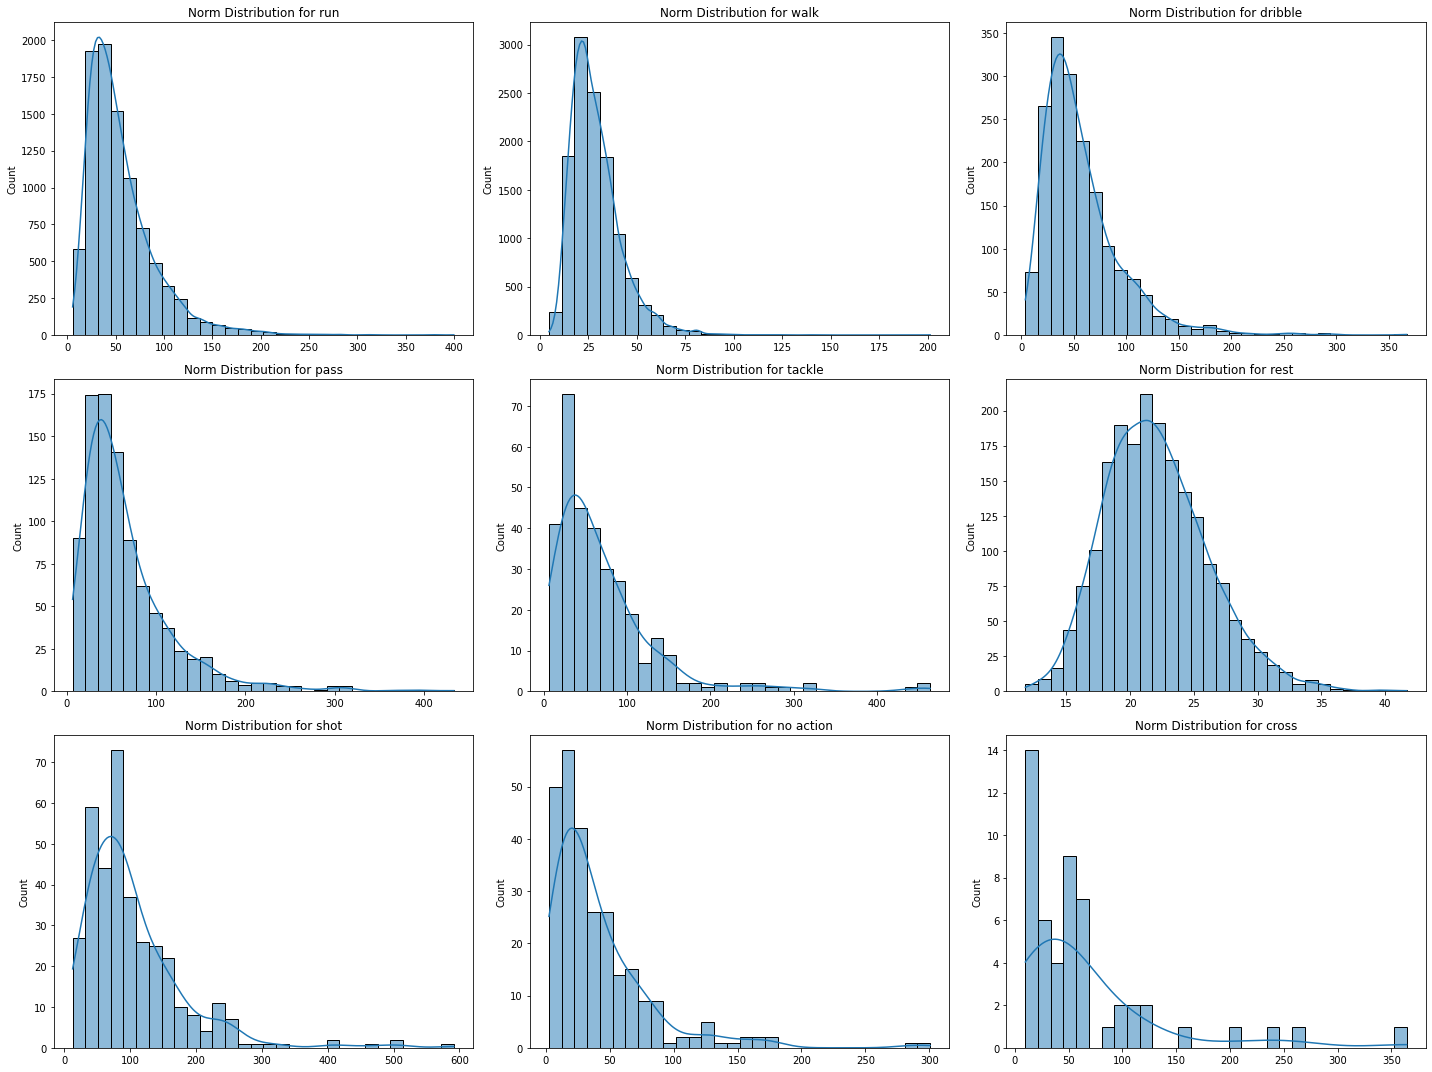

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting norms and labels for analysis
norms_data = [{'label': entry['label'], 'norm': entry['norm']} for entry in sampled_game]

# Converting to DataFrame for easier analysis
norms_df = pd.DataFrame(norms_data)

# Plotting histograms for each action
plt.figure(figsize=(20, 15))
actions = norms_df['label'].unique()

for i, action in enumerate(actions, 1):
    plt.subplot(3, 3, i)
    action_norms = [norm for sublist in norms_df[norms_df['label'] == action]['norm'].values for norm in sublist]
    sns.histplot(action_norms, bins=30, kde=True)
    plt.title(f'Norm Distribution for {action}')

plt.tight_layout()
plt.show()


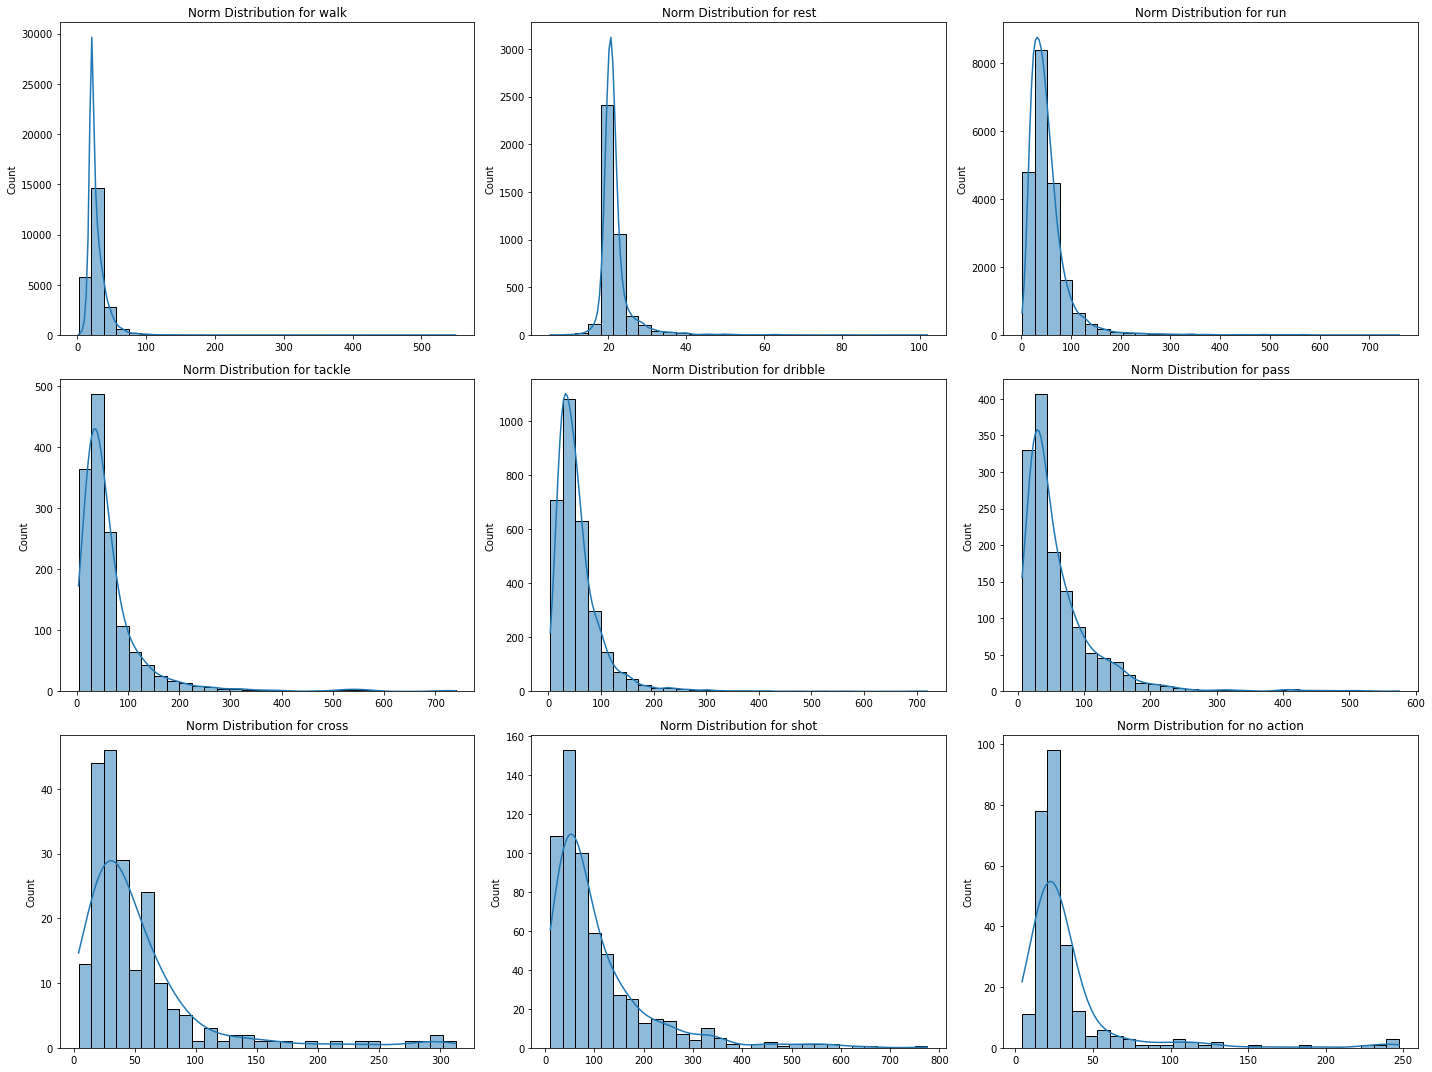

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting norms and labels for analysis
norms_data = [{'label': entry['label'], 'norm': entry['norm']} for entry in combined_data]

# Converting to DataFrame for easier analysis
norms_df = pd.DataFrame(norms_data)

# Plotting histograms for each action
plt.figure(figsize=(20, 15))
actions = norms_df['label'].unique()

for i, action in enumerate(actions, 1):
    plt.subplot(3, 3, i)
    action_norms = [norm for sublist in norms_df[norms_df['label'] == action]['norm'].values for norm in sublist]
    sns.histplot(action_norms, bins=30, kde=True)
    plt.title(f'Norm Distribution for {action}')

plt.tight_layout()
plt.show()


Optimizing the gait durations :

In [295]:
def assign_gait_length(action):
    """
    Assigns stochastic gait lengths to an action based on the gait lengths in the original dataset.
    """
    # Extracting gait lengths and labels for analysis
    gait_lengths_data = [{'label': entry['label'], 'gait_length': len(entry['norm']) / 50} for entry in combined_data]

    # Converting to DataFrame for easier analysis
    gait_lengths_df = pd.DataFrame(gait_lengths_data)

    # Calculate the average and standard deviation of gait lengths for each action
    gait_lengths_stats = gait_lengths_df.groupby('label').agg({
        'gait_length': ['mean', 'std']
    }).reset_index()
    
    # Extracting statistics for the action
    action_stats = gait_lengths_stats[gait_lengths_stats['label'] == action]
    avg_gait_length = action_stats[('gait_length', 'mean')].values[0]
    std_gait_length = action_stats[('gait_length', 'std')].values[0]

    # Sampling gait length from a normal distribution
    gait_length = np.abs(np.random.normal(loc=avg_gait_length, scale=std_gait_length))
    
    # Ensure gait length is within bounds, resample if not
    while gait_length < 0.1 or gait_length > 3:
        gait_length = np.abs(np.random.normal(loc=avg_gait_length, scale=std_gait_length))
        
    return gait_length

In [296]:
import numpy as np
import pandas as pd

def generate_game(start_action, desired_duration_minutes, game_style):
    game_sequence = [{'label': start_action, 'norm': assign_norm(start_action)}]
    total_gait_length = assign_gait_length(start_action)  # Initialize total gait length with start action gait length
    
    # A dictionary to hold the game style and corresponding adjustments to probabilities
    adjustment_factors = {
        'attacking': {'shot': 2, 'pass': 2, 'dribble': 1.5, 'cross':2},
        'defensive': {'tackle': 2, 'run': 2, 'pass': 0.5, 'dribble': 0.5}
    }
    
    while total_gait_length < desired_duration_minutes * 60:  # Convert minutes to seconds
        current_action = game_sequence[-1]['label']
        next_action_choices = list(transition_matrix.columns)
        next_action_probabilities = transition_matrix.loc[current_action].values.copy()
        
        # Adjust game style probabilities
        if game_style in adjustment_factors:
            for action, adjustment in adjustment_factors[game_style].items():
                next_action_probabilities[next_action_choices.index(action)] *= adjustment
        
        # Normalize the probabilities
        next_action_probabilities /= sum(next_action_probabilities)
        
        next_action = np.random.choice(next_action_choices, p=next_action_probabilities)
        
        # Check for constraints and adjust next action if necessary
        if len(game_sequence) >= 2 and game_sequence[-2]['label'] == next_action == 'shot':
            next_action = np.random.choice([action for action in next_action_choices if action != 'shot'])
        elif len(game_sequence) >= 2 and game_sequence[-2]['label'] == next_action == 'cross':
            next_action = np.random.choice([action for action in next_action_choices if action != 'cross'])
        
        norm_values = assign_norm(next_action)
        gait_length = assign_gait_length(next_action)
        game_sequence.append({'label': next_action, 'norm': norm_values})
        
        # Update total_gait_length with the gait length for the chosen action
        total_gait_length += gait_length
        
    return game_sequence

In [297]:
sampled_game = generate_game('run',9,'neutral')
sampled_game

[{'label': 'run',
  'norm': [44.49327587551365,
   31.6562395264843,
   44.13434931144561,
   70.77817786480327,
   18.791818183841904,
   68.26501212804418,
   57.126337328093236,
   43.35501624975187,
   36.84178955475658,
   28.769674378357877,
   59.18127606393783,
   83.67126339893933,
   103.04655865713355,
   61.523476263435,
   47.973557080527165,
   35.89513180342776,
   43.81851881131032,
   107.81791771262014,
   28.81207802423024,
   51.600204726503705,
   23.151280500666466,
   68.14954834786504,
   50.784217484485225,
   78.00967337216991,
   26.036540439929308,
   60.793967949186296,
   281.60625145172617,
   47.49522001146264,
   47.363453255420396,
   23.17182604373954,
   61.90813753119817,
   69.62160014356506,
   46.5205842879568,
   35.18749102888364,
   34.67603650699663,
   54.91197217194139,
   60.13295748671488]},
 {'label': 'run',
  'norm': [49.748589818017294,
   21.643686037416128,
   97.22262797157677,
   70.85041088539582,
   60.217248695781315,
   74.6328

In [298]:
gait_durations = [(len(gait['norm']) / 50) for gait in sampled_game]  # Divide by 50 to convert to seconds

fig = go.Figure()
fig.add_trace(go.Histogram(x=gait_durations, 
                           marker_color='blue',
                           opacity=0.75))

fig.update_layout(title_text='Distribution of Gait Durations',
                  xaxis_title='Duration (seconds)',
                  yaxis_title='Count',
                  bargap=0.05)

fig.show()

In [299]:
gait_durations = [(len(gait['norm']) / 50) for gait in match_data_1]  # Divide by 50 to convert to seconds

fig = go.Figure()
fig.add_trace(go.Histogram(x=gait_durations, 
                           marker_color='blue',
                           opacity=0.75))

fig.update_layout(title_text='Distribution of Gait Durations',
                  xaxis_title='Duration (seconds)',
                  yaxis_title='Count',
                  bargap=0.05)

fig.show()

## **Approach: Long Short-Term Memory (LSTM) Network**


In [10]:
import json
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data_1 = read_json('../data/match_1.json')
data_2 = read_json('../data/match_2.json')
data = data_1 + data_2  # Combining the data


In [11]:
sequences = [entry['label'] for entry in data]  

label_encoder = LabelEncoder()
encoded_sequences = label_encoder.fit_transform(sequences)

X = encoded_sequences[:-1]  
y = encoded_sequences[1:]  

y_one_hot = to_categorical(y)


In [12]:
# Reshape X for LSTM [samples, timesteps, features]
X_reshaped = np.reshape(X, (len(X), 1, 1))

model = Sequential()
model.add(LSTM(50, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Dense(y_one_hot.shape[1], activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_one_hot, test_size=0.2, random_state=0)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
30/30 [==============================] - 3s 25ms/step - loss: 1.9869 - accuracy: 0.4030 - val_loss: 1.8072 - val_accuracy: 0.6639
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6304 - accuracy: 0.6667 - val_loss: 1.5311 - val_accuracy: 0.4580
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3864 - accuracy: 0.4673 - val_loss: 1.3875 - val_accuracy: 0.4580
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2712 - accuracy: 0.5285 - val_loss: 1.3429 - val_accuracy: 0.6765
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2265 - accuracy: 0.6698 - val_loss: 1.3246 - val_accuracy: 0.6765
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 1.2045 - accuracy: 0.6656 - val_loss: 1.3094 - val_accuracy: 0.6639
Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 1.1884 - accuracy: 0.6698 - val_loss: 1.2925 - val_accuracy: 0.6765
Epoch 8/100


In [13]:
def generate_sequence(model, initial_action, num_steps):
    encoded_action = label_encoder.transform([initial_action])
    sequence = []
    for _ in range(num_steps):
        predicted = model.predict(np.reshape(encoded_action, (1, 1, 1)))
        predicted_action_encoded = np.argmax(predicted, axis=1)
        sequence.append(label_encoder.inverse_transform(predicted_action_encoded)[0])
        encoded_action = predicted_action_encoded
    return sequence

In [7]:
# Generate a sequence of actions starting with 'pass' and of length 10
generated_sequence = generate_sequence(model, 'pass', 10)


1/1 [==============================] - 0s 33ms/step


In [9]:
generated_sequence

['run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run']